In [1]:
import pandas as pd

In [2]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np

In [5]:
import seaborn as sns
sns.set()

In [6]:
from datetime import datetime, timedelta

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

---

In [8]:
df = pd.read_csv('X_train-1.csv')

In [9]:
df.shape

(15587, 11)

In [10]:
df.isnull().sum()

sku                     0
categoryLevel1Id        0
categoryLevel2Id        0
brandId                 0
property                0
userName                0
reting                  0
date                    0
comment                 0
commentNegative     14663
commentPositive     14664
dtype: int64

In [11]:
df.head()

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN
2,20020701,401,4010401,124,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",ddca2d0101513a6209db7868eed8be05,4.0,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,NaN,NaN
3,30012256,203,2030301,93,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",289c20015b3713a82ba5ddf774d996f7,5.0,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,NaN,NaN
4,30011341,205,2050201,656,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",5576f82d149d4f688644fef2322c63ef,5.0,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",NaN,NaN


In [12]:
df.rename(columns={'reting': 'rating'}, inplace=True)

In [13]:
df.commentNegative.fillna('', inplace=True)
df.commentPositive.fillna('', inplace=True)

In [16]:
# bins = np.array([0,1,2,3,4,5])
# df['rating_group'] = pd.cut(df.rating, bins, labels=[1,2,3,4,5])
# df['rating_group'] = df['rating_group'].astype(np.int64)
# df['rating_left'] = df.rating - df.rating_group

df['rating_group'] = np.round(df.rating)

In [18]:
df['sku_mils'] = df.sku // 1_000_000

In [19]:
parse_date = lambda d: datetime.strptime(d, '%Y-%m-%d')

df.date = df.date.apply(parse_date)

df['year']  = df.date.dt.year
df['month'] = df.date.dt.month
df['day']   = df.date.dt.day
df['dow']   = df.date.dt.dayofweek

year = datetime(2009,12,31) - datetime(2009,1,1)
df['temp'] = (df.date - df.date.dt.year.apply(lambda x: datetime(x,1,1))) / year * (2*np.pi)
df['date_sin'] = np.sin(df.temp)
df['date_cos'] = np.cos(df.temp)
df.drop(['temp'], axis=1, inplace=True)

In [20]:
rare_categories = df.categoryLevel1Id.value_counts()[df.categoryLevel1Id.value_counts() < 70].index
df.loc[df.categoryLevel1Id.isin(rare_categories), 'categoryLevel1Id'] = -1

rare_brands = df.brandId.value_counts()[df.brandId.value_counts() < 100].index
df.loc[df.brandId.isin(rare_brands), 'brandId'] = -1

In [21]:
extract_values = lambda x: ' '.join([v for d in eval(x) for k,v in d.items()])
df['properties_words'] = df.property.apply(extract_values)

In [22]:
%%time
results = []
for f,g in df.groupby('categoryLevel2Id'):
    cvec = CountVectorizer()
    a = cvec.fit_transform(g.properties_words).todense()
    a = np.hstack([a, g[['rating_group']]])
    a = pd.DataFrame(a)
    a.rename(columns={a.columns[-1]: 'target'}, inplace=True)
    results.append({ f: [a.corr(), cvec] })
    print('.', end='')

....................................................................................................................................................................CPU times: user 2.72 s, sys: 44 ms, total: 2.76 s
Wall time: 2.72 s


In [23]:
correlates = {}
for i in range(len(results)):
    d = results[i]
    for k in d.keys():
        t = d[k][0][['target']].dropna()
        t = t[(t.target > 0.5) & (t.target < 1)]
        if t.shape[0] > 1:
            features = { v: k for k,v in results[i][k][1].vocabulary_.items() }
            for x in t.index:
                correlates[features[x]] = t.loc[x][0]

In [24]:
def extract_property_corr(s):
    q = 0
    for t in s.split():
        if t in correlates:
            q += correlates[t]
    return q / float(len(s.split()))

In [25]:
df['property_corr'] = df.properties_words.apply(extract_property_corr)

In [26]:
df['text'] = df.comment + ' ' + df.commentNegative + ' ' + df.commentPositive

# EDA

## CategoryLevel1D

In [27]:
def corr_plane(df, feature1, feature2):
    x = df[[feature1, feature2]].copy()

    df_dummies = pd.get_dummies(df[feature1])
    del(df_dummies[df_dummies.columns[-1]])

    x_new = pd.concat([x, df_dummies], axis=1)
    del(x_new[feature1])

    c = x_new.corr(); c = c[:1]
    
    del(x); del(x_new)
    
    return c

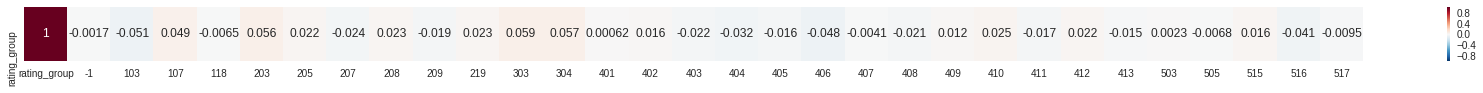

In [28]:
c = corr_plane(df, 'categoryLevel1Id', 'rating_group')

_,ax = plt.subplots(1,1,figsize=(30,1))
sns.heatmap(c, ax=ax, annot=True);

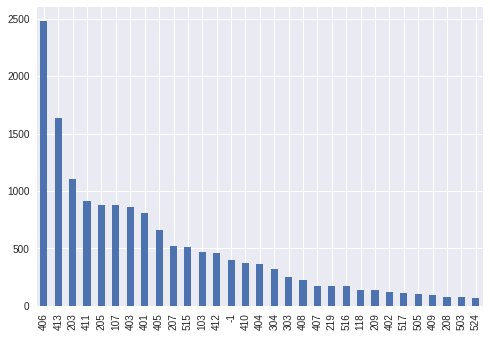

In [29]:
df.categoryLevel1Id.value_counts().plot.bar();

## CategoryLevel2D

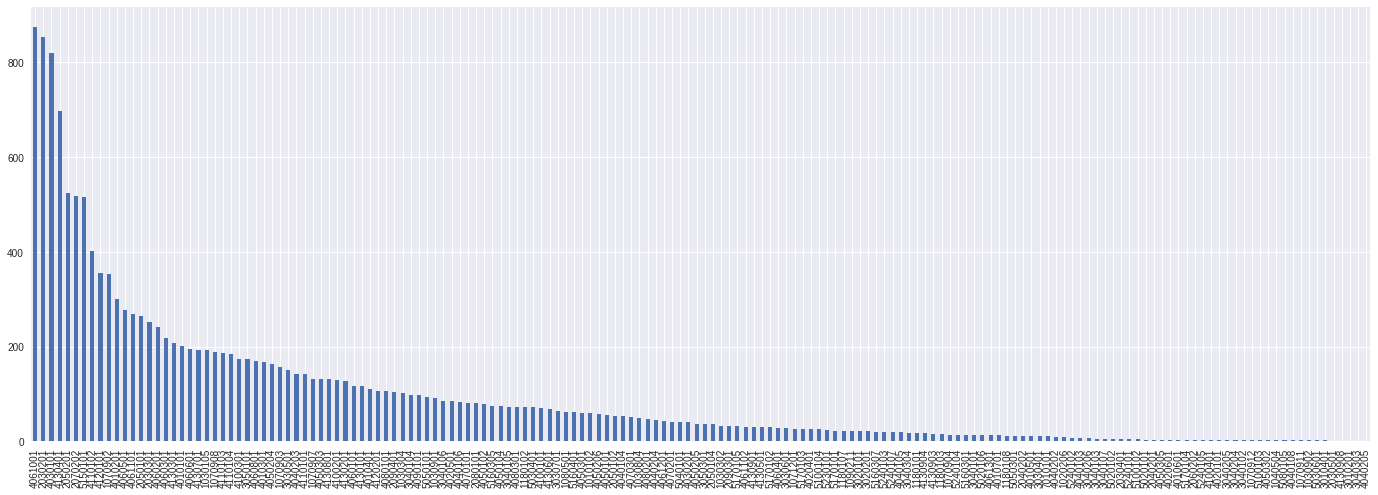

In [30]:
_,ax = plt.subplots(1,1,figsize=(24,8))
df.categoryLevel2Id.value_counts().plot.bar(ax=ax);

## BrandID

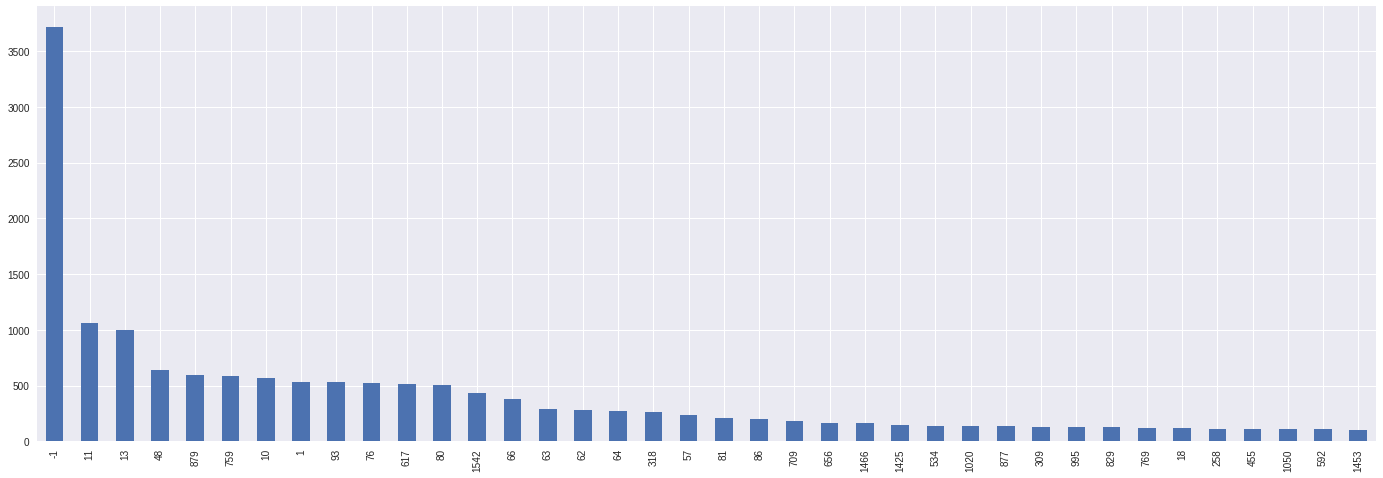

In [31]:
_,ax = plt.subplots(1,1,figsize=(24,8))
df.brandId.value_counts().plot.bar(ax=ax);

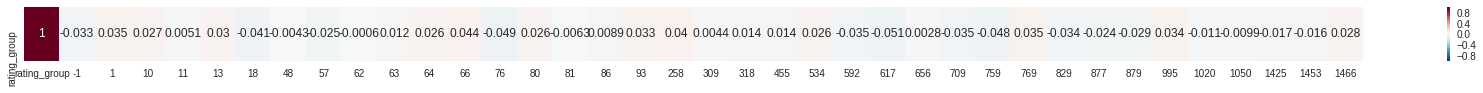

In [32]:
c = corr_plane(df, 'brandId', 'rating_group')

_,ax = plt.subplots(1,1,figsize=(30,1))
sns.heatmap(c, ax=ax, annot=True);

---

In [33]:
df_ = df[['categoryLevel1Id', 'categoryLevel2Id', 'brandId', 'rating_group', 'sku_mils', 
          'year', 'month', 'day', 'dow', 'date_sin', 'date_cos', 'property_corr']]

X = df_.drop('rating_group', axis=1)
y = df_.rating_group

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [38]:
%%time
clf = ExtraTreesClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)

print('ET:', np.mean(scores), '+/-', 2*np.std(scores))

ET: 0.530955642486 +/- 0.00729567645111
CPU times: user 7.38 s, sys: 20 ms, total: 7.4 s
Wall time: 7.39 s


In [37]:
%%time
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)

print('RF:', np.mean(scores), '+/-', 2*np.std(scores))

RF: 0.561750339123 +/- 0.0097556019811
CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.5 s


## Date

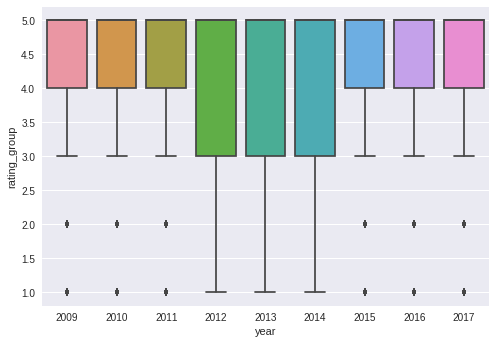

In [39]:
sns.boxplot(data=df, x='year', y='rating_group');

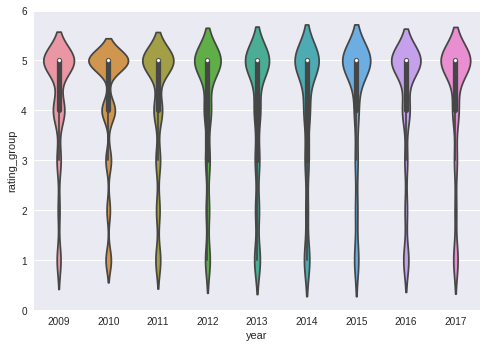

In [40]:
sns.violinplot(data=df, x='year', y='rating_group');

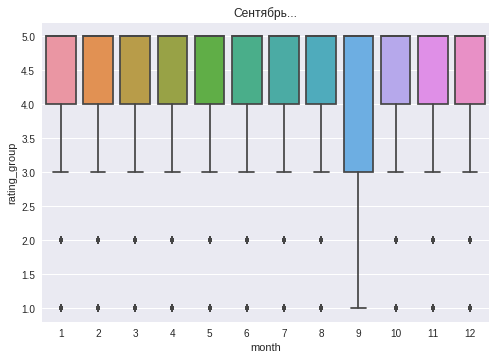

In [133]:
_,ax = plt.subplots(1,1)
sns.boxplot(data=df, x='month', y='rating_group', ax=ax);
ax.set_title('Сентябрь...');

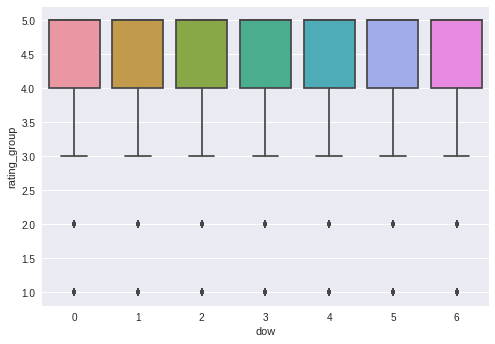

In [42]:
sns.boxplot(data=df, x='dow', y='rating_group');

# Предобработка

In [43]:
import re

from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

## Токенизация, стоп-слова и нормализация

In [44]:
ma = MorphAnalyzer()

normal_forms = {}

def w2vdfy(word):
    pos = ma.parse(word)[0].tag.POS
    pos = pos if pos is not None else 'UNKN'
    return word + '_' + pos


def preprocess(s):
    s = [x.lower() for x in re.findall(r'[а-яА-ЯёЁa-zA-Z]+', s) if len(x) > 1]
    s = [x for x in s if x not in stopwords.words('russian')] 
    
    q = []
    for x in s:
        if x in normal_forms:
            q.append(normal_forms[x])
        else:
            t = ma.parse(x)[0].normal_form
            q.append(t)
            normal_forms[x] = t
    
    s = q
    s2 = [w2vdfy(x) for x in s]
    
    return ' '.join(s), ' '.join(s2)


def preprocess_easy(s):
    return s.split()

In [45]:
%%time
normalized, normalized_with_pos = list(zip(*df.text.apply(preprocess)))
normalized_n, normalized_with_pos_n = list(zip(*df.commentNegative.apply(preprocess)))
normalized_p, normalized_with_pos_p = list(zip(*df.commentPositive.apply(preprocess)))

df['text_normalized']          = normalized
df['text_normalized_with_pos'] = normalized_with_pos

df['commentNegative_normalized']          = normalized_n
df['commentNegative_normalized_with_pos'] = normalized_with_pos_n

df['commentPositive_normalized']          = normalized_p
df['commentPositive_normalized_with_pos'] = normalized_with_pos_p

CPU times: user 3min 19s, sys: 5.39 s, total: 3min 25s
Wall time: 3min 25s


## Новые признаки от положительных и отрицательных отзывов

In [46]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [47]:
positive_texts = df.commentPositive_normalized[df.commentPositive_normalized.str.len() > 0]
negative_texts = df.commentNegative_normalized[df.commentNegative_normalized.str.len() > 0]

In [48]:
polars = pd.DataFrame(data={ 'text': list(positive_texts) + list(negative_texts) })
polars['polarity'] = np.hstack([np.ones_like(positive_texts), np.zeros_like(negative_texts)])
polars['polarity'] = polars['polarity'].astype(np.int64)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
polar_clf = Pipeline([
    ('cnt_vec', CountVectorizer()), 
    ('lg', LogisticRegression()),
])

In [51]:
X = polars.text
y = polars.polarity

In [52]:
polar_clf.fit(X, y);

In [53]:
scores = cross_val_score(polar_clf, X, y, cv=5)
print('Accuracy:', scores.mean(), '+/-', 2 * scores.std())

Accuracy: 0.891767068273 +/- 0.0150492057008


## Выведем топ самых характерных слов каждой полярности

In [54]:
import eli5

In [55]:
c = polar_clf.named_steps['cnt_vec'] 

In [56]:
f_names = [x[0] for x in sorted([(k,v) for k,v in c.vocabulary_.items()], key=lambda s: s[1])]

In [58]:
eli5.explain_weights(polar_clf.named_steps['lg'], feature_names=f_names, top=(10, 10))

Weight?,Feature
+2.387,советовать
+2.243,рекомендовать
+2.159,брать
+2.143,хороший
+2.126,отличный
+2.074,довольный
+2.044,купить
+1.800,пользоваться
+1.589,покупать
+1.457,чайник


---

In [59]:
from sklearn.dummy import DummyClassifier

In [60]:
dummy_clf = Pipeline([
    ('cnt_vec', CountVectorizer()),
    ('dummy', DummyClassifier(constant=5)),
]) 

In [61]:
scores = cross_val_score(dummy_clf, X, y, cv=5)
print('Accuracy:', scores.mean(), '+/-', 2 * scores.std())

Accuracy: 0.508723181012 +/- 0.0261472080317


# Кодирование

## Word2Vec

* https://radimrehurek.com/gensim/models/word2vec.html
* http://rusvectores.org/ru/models/ - Взял НКРЯ

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('ruscorpora_1_300_10.bin', binary=True)

In [125]:
def extract_word_value(word):
    try:
        return model[word]
    except:
        return np.zeros(300,)

In [126]:
def get_phrase_vector(phrase):
    result = np.sum(np.array([extract_word_value(x) for x in phrase.split()]), axis=0)
    if result.shape != (300,):
        result = np.zeros(300,)
    return result

# Модель и кросс-валидация

In [62]:
from sklearn.model_selection import KFold, StratifiedKFold

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, \
                                 LogisticRegression, LogisticRegressionCV

---

## Создание OOF-предсказаний

In [65]:
skf = StratifiedKFold(n_splits=5)
clf = LogisticRegression(C=1.0)

In [72]:
%%time
indices = []
answers = []

for train_indices, test_indices in skf.split(df, df.rating_group):
    indices.append(test_indices)
    
    X_train = df.text_normalized[train_indices]
    X_test  = df.text_normalized[test_indices]
        
    tfidf = TfidfVectorizer()
    X_train = tfidf.fit_transform(X_train).todense()
    X_test  = tfidf.transform(X_test).todense()
    
    y_train = df.rating_group[train_indices]
    y_test  = df.rating_group[test_indices]

    clf.fit(X_train, y_train);
    answers.append(clf.predict_proba(X_test))
    
    print('.', end='')
print()

.....
CPU times: user 9.06 s, sys: 2.91 s, total: 12 s
Wall time: 12 s


In [73]:
df.index

RangeIndex(start=0, stop=15587, step=1)

In [74]:
indices[0].shape

(3119,)

In [76]:
answers[0].shape

(3119, 5)

In [77]:
parts = []
for i in range(len(answers)):
    mini_df = answers[i]
    index   = indices[i]
    t = pd.DataFrame(data=mini_df, index=index)
    parts.append(t)

In [82]:
np.sum([t.shape[0] for t in parts])

15587

In [83]:
res = pd.concat(parts)

In [84]:
res.shape

(15587, 5)

In [86]:
res.rename(columns={
    0: 'P_1', 
    1: 'P_2',
    2: 'P_3',
    3: 'P_4',
    4: 'P_5'
}, inplace=True)

In [87]:
df = pd.merge(df, res, left_index=True, right_index=True, how='left')

---

In [96]:
df.head(1)

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,rating,date,comment,commentNegative,commentPositive,rating_group,rating_left,sku_mils,year,month,day,dow,date_sin,date_cos,properties_words,property_corr,text,text_normalized,text_normalized_with_pos,commentNegative_normalized,commentNegative_normalized_with_pos,commentPositive_normalized,commentPositive_normalized_with_pos,P_1,P_2,P_3,P_4,P_5
0,20005023,401,4010201,-1,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",,,2.0,0.0,20,2013,6,28,4,0.068991,-0.997617,f982777489055c6563d68c005fd24aad ba58121b2b2fb...,0.088823,"2,5 года работала и все...устала! Лампочка гор...",год работать устать лампочка гореть,год_NOUN работать_INFN устать_INFN лампочка_NO...,,,,,0.140641,0.085687,0.153297,0.122349,0.498027


In [97]:
useful_features = ['categoryLevel1Id', 'categoryLevel2Id', 'brandId',  'sku_mils', 
                   'year', 'month', 'day', 'dow', 'date_sin', 'date_cos', 'property_corr', 
                   'P_1', 'P_2', 'P_3', 'P_4', 'P_5']

In [98]:
X = df[useful_features]
y = df.rating

---

## Собственно, модель

* `r2`
* `neg_mean_absolute_error`
* `neg_mean_squared_error`

In [121]:
from lightgbm import LGBMClassifier, LGBMRegressor

In [122]:
%%time
clf = LGBMRegressor(n_estimators=100, nthread=24)
err = 'neg_mean_absolute_error'
scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring=err)
print(err, ': ', scores.mean(), '+/-', 2*scores.std())

neg_mean_absolute_error :  -0.606791096674 +/- 0.00304872349298
CPU times: user 204 ms, sys: 412 ms, total: 616 ms
Wall time: 4.12 s


In [123]:
from catboost import CatBoostRegressor

In [131]:
%%time
# INDIANA JONES MAIN THEME MUSIC INTENSIFIES
for seed in range(20): 
    clf = CatBoostRegressor(random_seed=seed)
    err = 'neg_mean_absolute_error'
    scores = cross_val_score(clf, X.values, y.ravel(), cv=5, n_jobs=-1, scoring=err)
    print('Seed', seed)
    print(err, ': ', scores.mean(), '+/-', 2*scores.std())
    print('---')

Seed 0
neg_mean_absolute_error :  -0.601862393341 +/- 0.00420801866624
---
Seed 1
neg_mean_absolute_error :  -0.601047651872 +/- 0.0042875570229
---
Seed 2
neg_mean_absolute_error :  -0.602195544668 +/- 0.00618976316039
---
Seed 3
neg_mean_absolute_error :  -0.60248092551 +/- 0.00327037407579
---
Seed 4
neg_mean_absolute_error :  -0.602098207555 +/- 0.00511775472962
---
Seed 5
neg_mean_absolute_error :  -0.601449305729 +/- 0.00560297585045
---
Seed 6
neg_mean_absolute_error :  -0.602648442757 +/- 0.00604236693354
---
Seed 7
neg_mean_absolute_error :  -0.60255287491 +/- 0.00488546183412
---
Seed 8
neg_mean_absolute_error :  -0.602313610246 +/- 0.00468901016045
---
Seed 9
neg_mean_absolute_error :  -0.601841844339 +/- 0.00374715244772
---
Seed 10
neg_mean_absolute_error :  -0.60276930715 +/- 0.00461738958109
---
Seed 11
neg_mean_absolute_error :  -0.601619659516 +/- 0.00636481330178
---
Seed 12
neg_mean_absolute_error :  -0.602159749629 +/- 0.00373217514219
---
Seed 13
neg_mean_absolute_

In [115]:
from xgboost import XGBRegressor

In [116]:
%%time
clf = XGBRegressor(n_jobs=-1, n_estimators=300)
err = 'neg_mean_absolute_error'
scores = cross_val_score(clf, X.values, y.ravel(), cv=5, n_jobs=-1, scoring=err)
print(err, ': ', scores.mean(), '+/-', 2*scores.std())

neg_mean_absolute_error :  -0.606530088442 +/- 0.00468668215429
CPU times: user 272 ms, sys: 328 ms, total: 600 ms
Wall time: 2min 2s


In [117]:
from mlxtend.classifier import StackingClassifier

In [119]:
%%time

clf = StackingClassifier(classifiers=[
    CatBoostRegressor(), 
    LGBMRegressor(nthread=24),
    XGBRegressor(n_jobs=-1),
], meta_classifier=LinearRegression())

err = 'neg_mean_absolute_error'
scores = cross_val_score(clf, X.values, y.ravel(), cv=5, n_jobs=-1, scoring=err)
print(err, ': ', scores.mean(), '+/-', 2*scores.std())

neg_mean_absolute_error :  -0.607890872171 +/- 0.0109486419023
CPU times: user 252 ms, sys: 392 ms, total: 644 ms
Wall time: 13.2 s


---

In [132]:
print('Итоговая точность (MAE): 0.600885532515 +/- 0.00415950181234')

Итоговая точность (MAE): 0.600885532515 +/- 0.00415950181234
